In [1]:
import random
from collections import deque
from copy import deepcopy

import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from IPython.display import clear_output

In [2]:
SEED = 1
BATCH_SIZE = 256
LR = 0.00030
UP_COEF = 0.005
GAMMA = 0.99
EPS = 1e-8
GRAD_NORM = False

# set device
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

# random seed
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if use_cuda:
    torch.cuda.manual_seed_all(SEED)

In [3]:
class DuelingDQN(nn.Module):
    def __init__(self, obs_space, action_space):
        super().__init__()

        self.head = nn.Sequential(
            nn.Linear(obs_space, obs_space*10),
            nn.SELU()
        )

        self.val = nn.Sequential(
            nn.Linear(obs_space*10, 512),
            nn.SELU(),
            nn.Linear(512, 512),
            nn.SELU(),
            nn.Linear(512, 1)
        )

        self.adv = nn.Sequential(
            nn.Linear(obs_space*10, 512),
            nn.SELU(),
            nn.Linear(512, 512),
            nn.SELU(),
            nn.Linear(512, action_space)
        )

    def forward(self, x):
        out = self.head(x)
        val_out = self.val(out).reshape(out.shape[0], 1)
        adv_out = self.adv(out).reshape(out.shape[0], -1)
        adv_mean = adv_out.mean(dim=1, keepdim=True)
        q = val_out + adv_out - adv_mean

        return q

In [4]:
losses = []


def learn(net, tgt_net, optimizer, rep_memory):
    net.train()
    tgt_net.train()

    train_data = random.sample(rep_memory, BATCH_SIZE)
    dataloader = DataLoader(
        train_data, batch_size=BATCH_SIZE, pin_memory=use_cuda)
    # double DQN
    for i, (s, a, r, _s, d) in enumerate(dataloader):
        s_batch = s.to(device).float()
        a_batch = a.detach().to(device).long()
        _s_batch = _s.to(device).float()
        r_batch = r.detach().to(device).float()
        done_mask = 1 - d.detach().to(device).float()
        
        _q_batch = net(_s_batch)
        _a_batch = torch.argmax(_q_batch, dim=1)

        with torch.no_grad():
            _q_batch_tgt = tgt_net(_s_batch)
            _q_best_tgt = _q_batch_tgt[range(BATCH_SIZE), _a_batch]

        q_batch = net(s_batch)
        q_acting = q_batch[range(BATCH_SIZE), a_batch]

        # loss
        loss = ((r_batch + GAMMA * done_mask* _q_best_tgt) - q_acting).pow(2).mean()
        losses.append(loss)

        optimizer.zero_grad()
        loss.backward()
        if GRAD_NORM:
            nn.utils.clip_grad_norm_(net.parameters(), max_norm=0.5)
        optimizer.step()


def select_action(obs, tgt_net):
    tgt_net.eval()
    with torch.no_grad():
        state = torch.tensor([obs]).to(device).float()
        q = tgt_net(state)
        action = torch.argmax(q, dim=1)

    return action.item()


def plot():
    clear_output(True)
    plt.figure(figsize=(16, 5))
    plt.subplot(121)
    plt.plot(rewards)
    plt.title('Reward')
    if len(losses) >= 2000:
        plt.subplot(122)
        plt.plot(losses[2000:])
        plt.title('Loss')
    plt.show()

## Main

In [5]:
# make an environment
# env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('LunarLander-v2')
env = gym.make('Breakout-ram-v0')

env.seed(SEED)
obs_space = env.observation_space.shape[0]
action_space = env.action_space.n

# hyperparameter
n_episodes = 100000
learn_start = 3000
memory_size = 100000
update_frq = 1
use_eps_decay = False
epsilon = 1.0
eps_min = 0.02
decay_rate = 0.0001
n_eval = env.spec.trials

# global values
total_steps = 0
learn_steps = 0
rewards = []
reward_eval = deque(maxlen=n_eval)
is_learned = False
is_solved = False

# make two nerual networks
net = DuelingDQN(obs_space, action_space).to(device)
target_net = deepcopy(net)

# make optimizer
optimizer = optim.Adam(net.parameters(), lr=LR, eps=EPS)

# make memory
rep_memory = deque(maxlen=memory_size)

/home/jay/anaconda3/lib/python3.7/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [6]:
env.spec.max_episode_steps

10000

In [7]:
env.spec.trials

100

In [8]:
env.spec.reward_threshold

KeyboardInterrupt: 

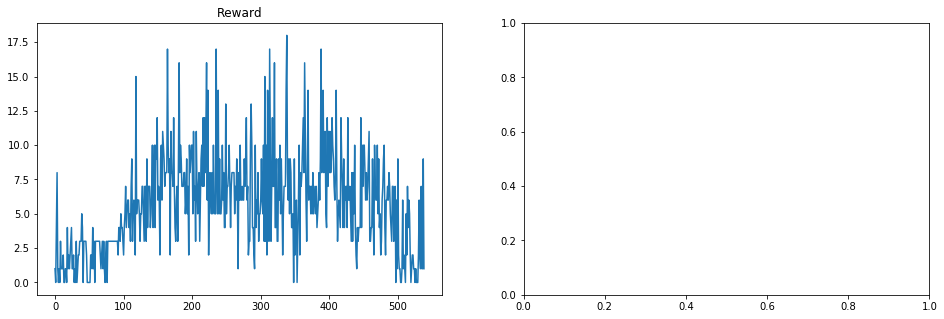

In [9]:
# play
for i in range(1, n_episodes + 1):
    obs = env.reset()
    done = False
    ep_reward = 0
    while not done:
#         env.render()
        if np.random.rand() < epsilon:
            action = env.action_space.sample()
        else:
            action = select_action(obs, target_net)

        _obs, reward, done, _ = env.step(action)

        rep_memory.append((obs, action, reward, _obs, done))

        obs = _obs
        total_steps += 1
        ep_reward += reward

        if use_eps_decay:
            epsilon -= epsilon * decay_rate
            epsilon = max(eps_min, epsilon)

        if len(rep_memory) >= learn_start:
            if len(rep_memory) == learn_start:
                epsilon = eps_min
                print('\n============  Start Learning  ============\n')
            learn(net, target_net, optimizer, rep_memory)
            learn_steps += 1

        if learn_steps == update_frq:
            # target smoothing update
            for t, n in zip(target_net.parameters(), net.parameters()):
                t.data = UP_COEF * n.data + (1 - UP_COEF) * t.data
            learn_steps = 0
    if done:
        rewards.append(ep_reward)
        reward_eval.append(ep_reward)
        plot()
#         print('{:3} Episode in {:5} steps, reward {:.2f}'.format(
#             i, total_steps, ep_reward))

        if len(reward_eval) >= n_eval:
#             if np.mean(reward_eval) >= env.spec.reward_threshold:
            if np.mean(reward_eval) >= 400:
                print('\n{} is sloved! {:3} Episode in {:3} steps'.format(
                    env.spec.id, i, total_steps))
                torch.save(target_net.state_dict(),
                           f'./test/saved_models/{env.spec.id}_ep{i}_clear_model_dddqn.pt')
                break
env.close()

In [ ]:
[
    ('CartPole-v0', 390, 0.25),
    ('CartPole-v1', 346, 0.25),
    ('MountainCar-v0', 810, 0.25),
    ('LunarLander-v2', 370, 0.25)
]